# Preliminary Summer Model Experiments (May - Aug?)
---
### *Timeline*
#### -- PART 1 (Base binary test) --

0. [ ] Import grid-placed houses with JS world edit - Tim
1. [ ] Create pure house dataset - Tim
2. [x] Create binary house dataset - Tim 
3. [ ] Test previous experiment models - M + Tim
    - [x] Original models (VAE, GAN) (M)
    - [x] New VAE (M)
    - [ ] New GAN (Tim)
    - [ ] New VAEGAN (M)
    
#### -- PART 2 (Block test) --

4. [ ] Use channels and repeat step #3

#### -- PART 3 (Full dataset test) --

5. [ ] Use the full dataset of buildings
    - 5a. If unsuccessful, problem is with "crazy" buildings - scrap altogether or try separate model (step #2+)
    - 5b. Else, continue anyways!

#### -- PART 4 (Fun experiments) --

6. Novelty experiments (see notebook: [link to notebook here])
7. Interactive evolution experiments (see notebook: [link to notebook here])
8. Latent space exploration experiments (see notebook: [link to notebook here])

In [1]:
DEBUG = True

---
### Imports

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from v1b.VAE16 import VAE_3D
import v1b.visualizer as vis
import v1b.preprocessing3Dcraft as preproc

%matplotlib inline

15
[ 0  2  5 12 64 85]
[ 0  2  3  5 12 14]


2022-06-13 14:55:15.309448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


737


### Test Original Models

In [3]:
## VAE TEST
'''
-- Notes --
 > architecture isn't perfectly mirrored in layer sizes on encoder to decoder
 > takes a REALLY long time to train
'''
 
skip = True
if not skip:
    og_vae = VAE_3D()
    og_vae.train(epochs=500, batch_size=128)

ENCODER
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 16, 16,  0           []                               
                                 11)]                                                             
                                                                                                  
 conv3d (Conv3D)                (None, 16, 16, 16,   90240       ['input_1[0][0]']                
                                128)                                                              
                                                                                                  
 batch_normalization (BatchNorm  (None, 16, 16, 16,   512        ['conv3d[0][0]']                 
 alization)                     128)                                                  

                                                                 
 conv3d_6 (Conv3D)           (None, 16, 16, 16, 64)    262208    
                                                                 
 batch_normalization_9 (Batc  (None, 16, 16, 16, 64)   256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 16, 16, 16, 64)    0         
                                                                 
 conv3d_7 (Conv3D)           (None, 16, 16, 16, 128)   524416    
                                                                 
 batch_normalization_10 (Bat  (None, 16, 16, 16, 128)  512       
 chNormalization)                                                
                                                                 
 activation_7 (Activation)   (None, 16, 16, 16, 128)   0         
                                                                 
 conv3d_8 

/Users/milk/anaconda3/envs/MCIntEvo/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 1/51 [..............................] - ETA: 46:16 - loss: 3.2605 - accuracy: 0.0887

KeyboardInterrupt: 

### Make new visualizers

In [4]:
def show3D(builds, binary=True, textArr=None):
    fig = plt.figure(figsize=(20,7))
    col = 8
    
    if binary:
        colors = 'red'
    else:
        colors = 'red' #replace later with colors for each block id value [0-12]
    
    for i, build in enumerate(builds):
        ax = fig.add_subplot(int(len(builds) / col) + 1, col, i + 1,  projection='3d')
        ax.voxels(build, edgecolor="k", facecolors=colors, linewidth=0.5)
        plt.axis('off')
        if textArr != None:
            plt.title(textArr[i])
    plt.show()

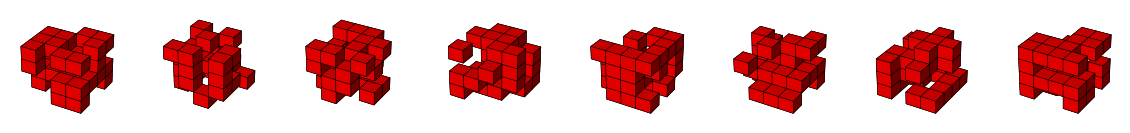

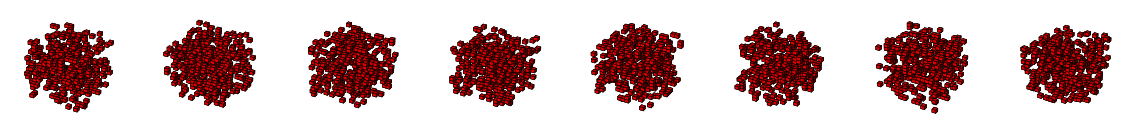

In [5]:
if DEBUG:
    n = 8
    rand_builds = [np.random.randint(0,2,size=(4,4,4)) for i in range(n)]
    rand_builds16 = [np.zeros(shape=(16,16,16)) for i in range(n)]

    # give random values for fun
    for i in range(n):
        for j in range(400):
            rand_builds16[i][random.randint(0,15)][random.randint(0,15)][random.randint(0,15)] = 1

    show3D(rand_builds)
    show3D(rand_builds16)

### Import the dataset

In [56]:
HOUSE_DATASET = []
HOUSE_DATASET_BIN = []
HOUSE_DATASET_ONEHOT = []

house_combined = np.load('../ingame_house_schematics/old_format_schematic_files/combined.npy')
blocks = []
for h in house_combined:
    # houses look rotated... just rotate them back
    h = np.rot90(h,axes=(0,2))
    
    # remove bottom layer (got the ground as well) - i can't believe i got it right on the first try...
    h = h[3:, 3:, 1:-2]
    HOUSE_DATASET.append(h)
    
    
    #HOUSE_DATASET_ONEHOT.append(h)
    
    #hc = np.argmax(h,axis=2)
    #HOUSE_DATASET.append(hc)
    idx = np.nonzero(h)
    hb = np.zeros(shape=h.shape)
    for i in range(len(idx[0])):
        a,b,c = idx
        hb[a[i]][b[i]][c[i]] = 1
    HOUSE_DATASET_BIN.append(hb)
        
HOUSE_DATASET = np.array(HOUSE_DATASET)
HOUSE_DATASET_BIN = np.array(HOUSE_DATASET_BIN)
HOUSE_DATASET_ONEHOT = np.array(HOUSE_DATASET_ONEHOT)

In [57]:
print(np.array(HOUSE_DATASET_BIN[0]).shape)

(16, 16, 16)


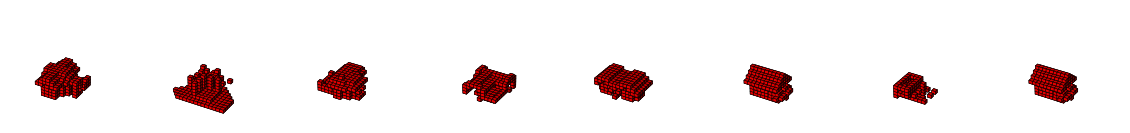

In [58]:
# show a few random ones to verify
if DEBUG:
    show3D(HOUSE_DATASET_BIN[random.choices(list(range(len(HOUSE_DATASET_BIN))),k=8)])

### Try new models

**VAE Test** 
- taken from AestheticBot prelim experiments -> taken from Diversity + NoveltyPrints project
- modified to be in 3d

In [96]:
from keras.models import Model
from keras import backend as K
from keras import Input
from keras import Sequential
from keras.layers import Dense, BatchNormalization, Conv3DTranspose, LeakyReLU, Reshape, ReLU, Conv3D, Flatten, MaxPooling3D

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        mean_mu, log_var = inputs
        epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
        return mean_mu + K.exp(log_var/2)*epsilon
    

class VAE(Model):
    def __init__(self,zshape,batches=1,channels=1):
        super(VAE, self).__init__()
        
        self.channels = channels
        self.latent_dim = zshape
        self.batch_size = batches
        self.nn_size = 16
        
        #make the models
        self.makeEncoder()
        self.makeDecoder()
        
    #makes the encoder model for the VAE
    def makeEncoder(self):
        
        #variational encoder
        enc_in = Input(shape=(self.nn_size, self.nn_size, self.nn_size, self.channels))
        x = Conv3D(self.channels*2, kernel_size=2, padding='same', strides=2)(enc_in)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU()(x)
        x = Conv3D(self.channels*4, kernel_size=2, padding='same', strides=2)(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = LeakyReLU()(x)
#         x = Conv3D(self.channels*8, kernel_size=2, padding='same', strides=2)(x)
#         x = LeakyReLU()(x)
        x = Flatten()(x)
        
        #variational sampling
        z_mean = Dense(self.latent_dim, name="z_mean")(x)
        z_log_var = Dense(self.latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
            
        #combine together
        self.encoder = Model(enc_in, [z_mean, z_log_var, z], name='encoder')
        
        if DEBUG:
            self.encoder.summary()
        
    #makes the decoder model for the VAE
    def makeDecoder(self):
        #normal decoder
        dec_in = Input(shape=(self.latent_dim,))
        s = self.nn_size//4
        y = Dense(s*s*s*4*self.channels, activation="relu")(dec_in)  #product of output shape of autoencoder
        y = Reshape((s,s,s,4*self.channels))(y)  #output shape of autoencoder
        
        
#         s = self.nn_size//8
#         y = Dense(s*s*s*8*self.channels, activation="relu")(dec_in)  #product of output shape of autoencoder
#         y = Reshape((s,s,s,8*self.channels))(y)  #output shape of autoencoder
#         y = Conv3DTranspose(self.channels*4, kernel_size=4, strides=2, padding='same')(y)
#         y = LeakyReLU()(y)
        y = Conv3DTranspose(self.channels*2, kernel_size=2, strides=2, padding='same')(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU()(y)
        y = Conv3DTranspose(self.channels, kernel_size=2, strides=2, padding='same')(y)
        y = BatchNormalization(momentum=0.8)(y)
        y = LeakyReLU()(y)
        dec_out = Conv3DTranspose(self.channels, kernel_size=3, activation='sigmoid', padding='same')(y)
        self.decoder = Model(dec_in, dec_out)

        
        if DEBUG:
            self.decoder.summary()
     
    #define loss functions
    
    #reconstructed loss
    def r_loss(self,y_true, y_pred):
#         return K.mean(K.square(tf.cast(y_true,tf.float32) - tf.cast(y_pred,tf.float32)), axis = [1,2,3])
        return tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true, y_pred), axis=(1,2,3)))
        
    #kl-divergence loss
    def kl_loss(self,log_var, mean):
#         return -0.5 * K.sum(1 + log_var - K.square(mean) - K.exp(log_var), axis = 1)
        kl_loss = -0.5 * (1 + log_var - tf.square(mean) - tf.exp(log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=(1)))
        return kl_loss
    
    #singular step for training
    def train_step(self, data):    
        with tf.GradientTape() as tape:
            #get output encoding and reconstruct from latent vector
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #VAE loss function - MSE + KL DIVERGENCE
            reconstruction_loss = self.r_loss(data,reconstruction)
            kl = self.kl_loss(z_log_var,z_mean)
#             tl = 10000*reconstruction_loss+kl
            tl = reconstruction_loss+kl
             
        #apply loss back to weights
        grads = tape.gradient(tl, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        return {"recon loss":reconstruction_loss, "kl loss":kl, "total loss": tl}

In [102]:
# VAE TEST

#setup
EPOCHS = 100
BATCH_SIZE = 16
Z_SIZE = 25
CHANNELS = 1

if CHANNELS == 11:
    INPUT_DATA = HOUSE_DATASET_ONEHOT
else:
    INPUT_DATA = np.expand_dims(HOUSE_DATASET_BIN,axis=4)
    

#create batch data
train_dat = tf.data.Dataset.from_tensor_slices(INPUT_DATA).shuffle(len(INPUT_DATA)).batch(BATCH_SIZE)

# create the VAE
HOUSE_VAE = VAE(Z_SIZE,BATCH_SIZE,CHANNELS)
HOUSE_VAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

# train the VAE
history = HOUSE_VAE.fit(train_dat,epochs=EPOCHS,batch_size=BATCH_SIZE,shuffle=True,verbose=True)

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_28 (InputLayer)          [(None, 16, 16, 16,  0           []                               
                                 1)]                                                              
                                                                                                  
 conv3d_33 (Conv3D)             (None, 8, 8, 8, 2)   18          ['input_28[0][0]']               
                                                                                                  
 batch_normalization_43 (BatchN  (None, 8, 8, 8, 2)  8           ['conv3d_33[0][0]']              
 ormalization)                                                                                    
                                                                                            

9/9 [==============================] - 0s 46ms/step - recon loss: 777.4627 - kl loss: 113.7612 - total loss: 891.2239
Epoch 24/100
9/9 [==============================] - 0s 43ms/step - recon loss: 724.0326 - kl loss: 102.6900 - total loss: 826.7226
Epoch 25/100
9/9 [==============================] - 0s 40ms/step - recon loss: 679.3484 - kl loss: 96.3093 - total loss: 775.6577
Epoch 26/100
9/9 [==============================] - 0s 38ms/step - recon loss: 659.4526 - kl loss: 89.3736 - total loss: 748.8262
Epoch 27/100
9/9 [==============================] - 0s 36ms/step - recon loss: 635.1772 - kl loss: 80.5777 - total loss: 715.7549
Epoch 28/100
9/9 [==============================] - 0s 44ms/step - recon loss: 625.1247 - kl loss: 73.5360 - total loss: 698.6607
Epoch 29/100
9/9 [==============================] - 0s 40ms/step - recon loss: 610.0717 - kl loss: 67.8712 - total loss: 677.9429
Epoch 30/100
9/9 [==============================] - 0s 40ms/step - recon loss: 599.6340 - kl loss: 64

9/9 [==============================] - 0s 35ms/step - recon loss: 391.4881 - kl loss: 27.6476 - total loss: 419.1357
Epoch 87/100
9/9 [==============================] - 0s 34ms/step - recon loss: 388.0904 - kl loss: 27.9165 - total loss: 416.0068
Epoch 88/100
9/9 [==============================] - 0s 34ms/step - recon loss: 387.6055 - kl loss: 28.1831 - total loss: 415.7886
Epoch 89/100
9/9 [==============================] - 0s 35ms/step - recon loss: 391.6128 - kl loss: 27.4949 - total loss: 419.1077
Epoch 90/100
9/9 [==============================] - 0s 37ms/step - recon loss: 393.5074 - kl loss: 28.8398 - total loss: 422.3472
Epoch 91/100
9/9 [==============================] - 0s 37ms/step - recon loss: 383.1392 - kl loss: 26.9120 - total loss: 410.0512
Epoch 92/100
9/9 [==============================] - 0s 36ms/step - recon loss: 390.7978 - kl loss: 27.7388 - total loss: 418.5366
Epoch 93/100
9/9 [==============================] - 0s 36ms/step - recon loss: 385.5343 - kl loss: 27.1

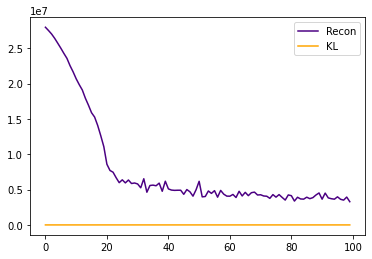

In [103]:
plt.plot(np.array(history.history['recon loss']).squeeze()*10000,label=f'Recon',color='indigo')
plt.plot(np.array(history.history['kl loss']).squeeze(),label=f'KL',color='orange')
plt.legend()

In [104]:
# show reconstruction from the VAE
def reconVAETest(vae_model,testData):
    # get prediction output
    encoded_imgs = vae_model.encoder.predict(testData)
    decoded_imgs = np.around(vae_model.decoder.predict(encoded_imgs[2]).squeeze())
    
    # show the two outputs on top of each other
    show3D(testData.squeeze())
    show3D(decoded_imgs)
    
# generate and show new sample from the VAE
def generateVAESamples(vae_model,n=8,zsize=20):
    vae_samples = np.around(vae_model.decoder.predict(np.random.normal(0,1,size=(n,zsize))).squeeze())
    show3D(vae_samples)

RECON
1/1 [==============================] - 0s 153ms/step


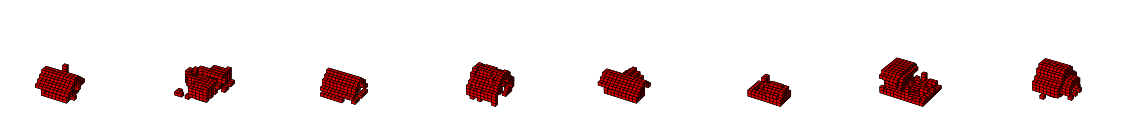

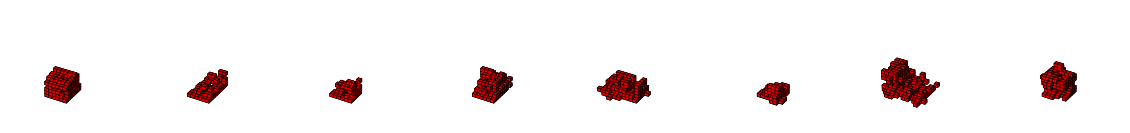

SAMPLE
1/1 [==============================] - 0s 21ms/step


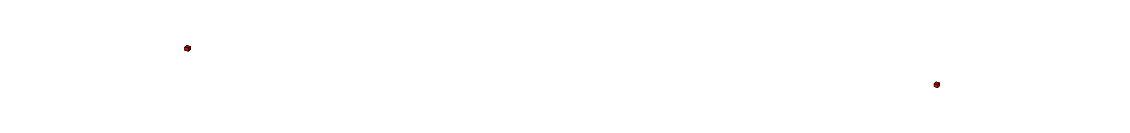

In [105]:
if DEBUG:
    print("RECON")
    rand_index = random.choices(list(range(len(INPUT_DATA))),k=8)
    RAND_SEL = INPUT_DATA[rand_index]
    reconVAETest(HOUSE_VAE,RAND_SEL)
    
    print("SAMPLE")
    generateVAESamples(HOUSE_VAE,zsize=Z_SIZE)